In [10]:
import numpy as np
from numba import jit, float64
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Route to chaos
## What is the value of b

$$
\dot x = sin(y) - bx \\
\dot y = sin(z) - by  \\
\dot z = sin(x) - bz
$$

Fixed point of the form $x=y=z=\alpha$ leads to $sin(\alpha) = b*alpha$


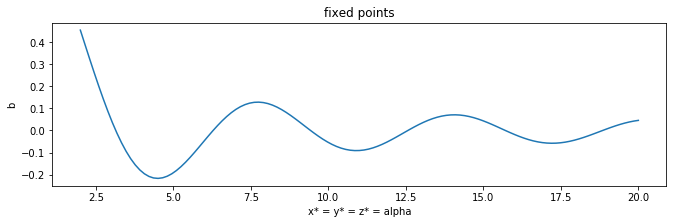

In [7]:
plt.figure(figsize=(11, 3))
alpha = np.linspace(2., 20, 123)
plt.plot(alpha, np.sin(alpha)/alpha);
plt.xlabel('x* = y* = z* = alpha'); plt.ylabel('b');
plt.title('fixed points');

In [42]:
@jit(float64[:](float64[:], float64), nopython=True)
def thomas_attractor(xyz, b):
    ''' ODE for Thomas attractor
        xyz: point positions, shape (dim, )
    '''
    sin_xyz = np.sin(xyz)
    dYdt = -b*xyz
    dYdt[0] += sin_xyz[1]
    dYdt[1] += sin_xyz[2]
    dYdt[2] += sin_xyz[0]
    return dYdt

xyz = np.random.rand(3)
_ = thomas_attractor(xyz, 0.21)

## Time to reach the attractor (burn step)

In [63]:
b = 0.195

In [72]:
t_end = 150
all_sol = []
for _ in range(20):
    y0 = np.random.randn(3)*3
    sol = solve_ivp(lambda t, y: thomas_attractor(y, b), (0, t_end), y0,
                    method='RK23')
    all_sol.append(sol)

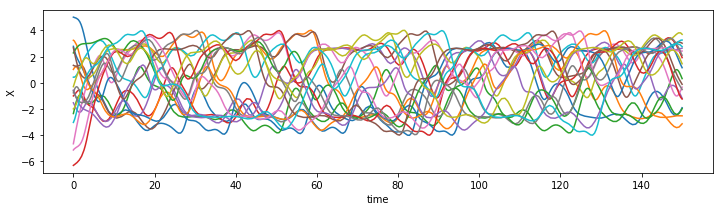

In [73]:
fig, ax1 = plt.subplots(1, 1, sharex=True,
                                    figsize=(12, 3))
for sol in all_sol:
    ax1.plot(sol.t, sol.y[0, :], '-', label=name);
    ax1.set_ylabel('X');
    
#ax1.legend();
ax1.set_xlabel('time');

ce n'est pas un test suffisant: b=.19 --> un seul cycle pour t=500

In [89]:
def burn(b):
    y0 = np.random.randn(3)*3
    t_end = 500
    sol = solve_ivp(lambda t, y: thomas_attractor(y, b), (0, t_end), y0,
                    method='RK23', vectorized=False)
    y0 = sol.y[:, -1]
    return y0

    b = .171  3 cycles
    b = .172

    .19   1 cycle

In [86]:
b = 0.19
all_y0 = [burn(b) for _ in range(10)]

In [87]:
method = 'RK23'
t_end = 250
all_sol = []
for y0 in all_y0:
    sol = solve_ivp(lambda t, y: thomas_attractor(y, b), (0, t_end), y0,
                                method=method, vectorized=False,
                                rtol=1e-6, atol=1e-5,
                                first_step=.1)
    all_sol.append(sol)

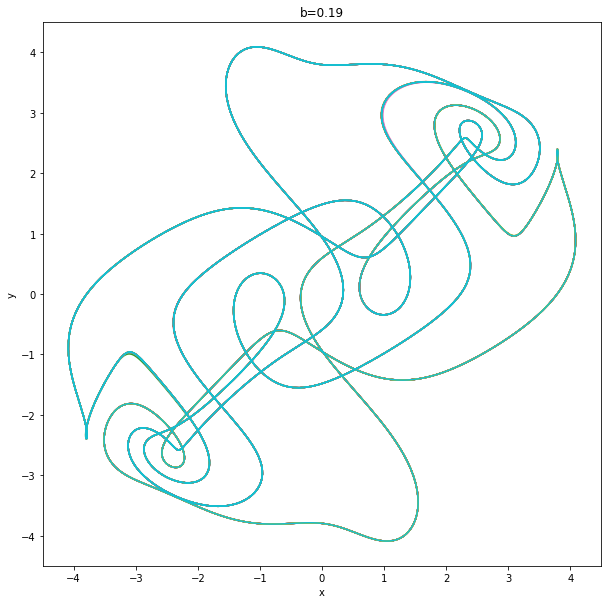

In [88]:
plt.figure(figsize=(10, 10))

for sol in all_sol:
    plt.plot(sol.y[0, :], sol.y[1, :])
    
plt.xlabel('x'); plt.ylabel('y'); plt.title(f'b={b}');

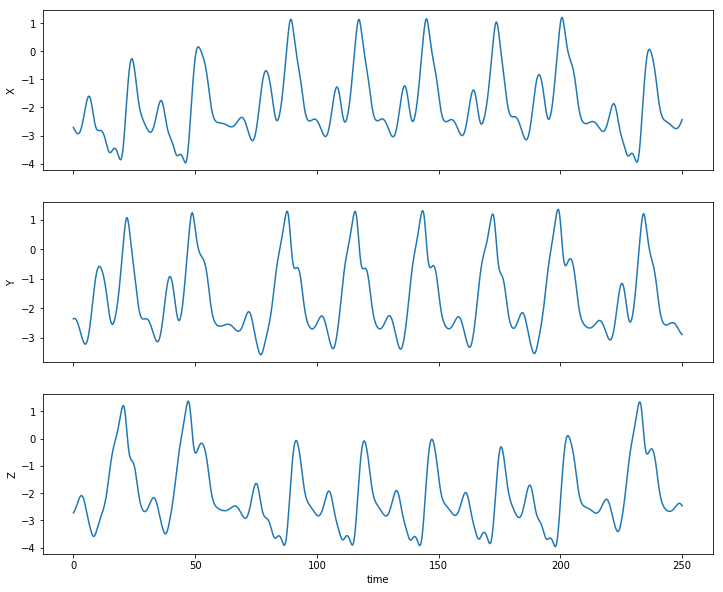

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True,
                                    figsize=(12, 10))
name = 'method'
for sol in all_sol:
    ax1.plot(sol.t, sol.y[0, :], '-', label=name);
    ax2.plot(sol.t, sol.y[1, :], '-', label=name);
    ax3.plot(sol.t, sol.y[2, :], '-', label=name);
    ax1.set_ylabel('X');
    ax2.set_ylabel('Y');
    ax3.set_ylabel('Z');
    break
    
#ax1.legend();
ax3.set_xlabel('time');

ds_avg: 0.08657896787497538 0.03188261529544831


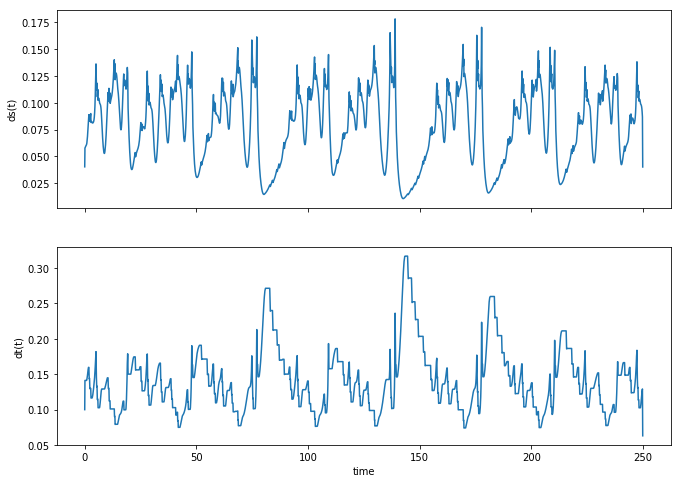

In [41]:
# Time steps and ds
sol = all_sol[-1]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,
                                    figsize=(11, 8))

ds = np.sqrt(np.sum(np.diff(sol.y, axis=1)**2, axis=0))
print('ds_avg:', ds.mean(), ds.std())

ax1.plot(sol.t[:-1], ds, '-', label='ds');
ax1.set_ylabel('ds(t)');

ax2.plot(sol.t[:-1], np.diff(sol.t), '-', label='dt');
ax2.set_ylabel('dt(t)');

ax2.set_xlabel('time');

## Graph local_max(x) function of b

In [197]:
from multiprocessing import Pool
import time

In [156]:
@jit(float64[:](float64[:]), nopython=True)
def find_local_max(x):
    dx = x[1:] - x[:-1] # np.diff(x)
    max_x = x[1:-1][ np.logical_and(dx[:-1]>0, dx[1:]<0) ]
    return max_x

In [159]:
%%timeit
_ = find_local_max(x)

# no jit: 9.52 µs ± 143 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
# jit: 3.82 µs ± 76.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

9.73 µs ± 336 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [337]:
t_end = 300
nunber_of_seed = 30

def sample_for_b(b):
    
    # burn
    all_y0 = [burn(b) for _ in range(nunber_of_seed)]

    max_x_for_b = []
    for y0 in all_y0:
        sol = solve_ivp(lambda t, y: thomas_attractor(y, b), (0, t_end), y0,
                                     method='RK23', vectorized=False,
                                     rtol=1e-6, atol=1e-5,
                                     first_step=.1)
        max_x_for_b.extend(find_local_max(sol.y[0, :]))
        
    return max_x_for_b

In [205]:
dix_millieme = np.arange(1100, 2000, 5)
b_span = dix_millieme/10000

print(len(b_span))

180


In [206]:
t_start = time.time()
with Pool(6) as p:
    all_max_x = p.map(sample_for_b, b_span)
    
print('elapsed (s)', time.time() - t_start)

elapsed (s) 85.8491473197937


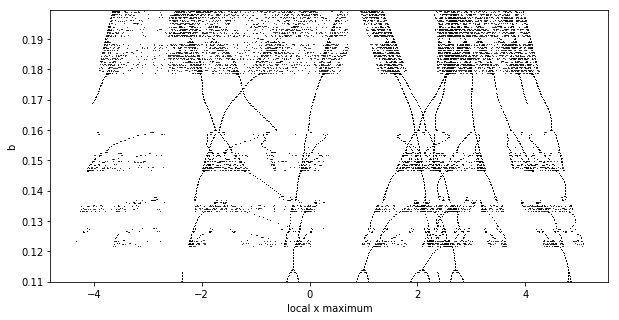

In [212]:
# Graph
plt.figure(figsize=(10, 5))
for b, max_x in zip(b_span, all_max_x):
    plt.plot(max_x, [b, ]*len(max_x), ',',
             color='black', alpha=0.75)
    
plt.xlabel('local x maximum'); plt.ylabel('b');
plt.ylim([b_span.min(), b_span.max()]);

#### zoom

In [338]:
cent_millieme = np.arange(18000, 19300, 5)
b_span = cent_millieme/100000

print(len(b_span))

260


In [339]:
t_start = time.time()
with Pool(6) as p:
    all_max_x = p.map(sample_for_b, b_span)
    
print('elapsed (s)', time.time() - t_start)

elapsed (s) 371.6222593784332


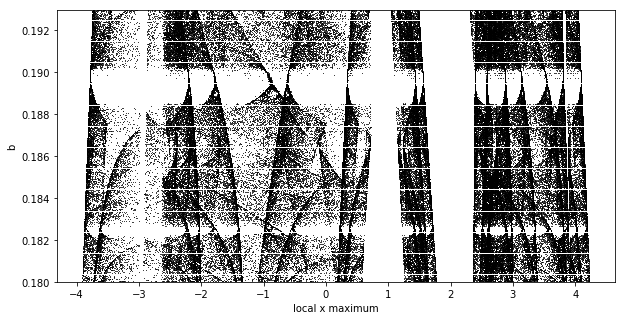

In [340]:
# Graph
plt.figure(figsize=(10, 5))
for b, max_x in zip(b_span, all_max_x):
    plt.plot(max_x, [b, ]*len(max_x), ',',
             color='black', alpha=0.75)
    
plt.xlabel('local x maximum'); plt.ylabel('b');
plt.ylim([b_span.min(), b_span.max()]);

### test multiprocessing

In [168]:
def f(x):
    time.sleep(1)
    return x*x

In [178]:
t_start = time.time()
with Pool(5) as p:
    print(p.map(f, [1, 2, 3, 4, 5]))
print('elapsed', time.time() - t_start)

[1, 4, 9, 16, 25]
elapsed 1.1456918716430664


In [176]:
t_start = time.time()
[f(u) for u in [1, 2, 3, 4, 5]]
print('elapsed', time.time() - t_start)

elapsed 5.0060224533081055


## Entropy

measure how much the values are distributed

_note:_ [Error estimation for MC methods](https://ocw.mit.edu/courses/aeronautics-and-astronautics/16-90-computational-methods-in-aerospace-engineering-spring-2014/probabilistic-methods-and-optimization/error-estimates-for-the-monte-carlo-method/)

In [289]:
def entropy(x):
    x_range = [-4., 4.3]
    N_bins = 100
    x = np.asarray(x)

    x_scaled =  (x - x_range[0])/(x_range[1] - x_range[0])*N_bins

    p_i = np.bincount( np.floor(x_scaled).astype(int) )/len(x)
    p_i = p_i[p_i>0]
    S = -np.sum(p_i*np.log(p_i))
    return S

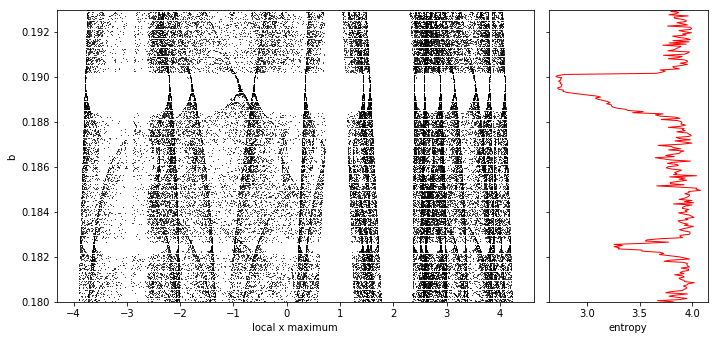

<Figure size 720x360 with 0 Axes>

In [290]:
S = [entropy(x_max) for x_max in all_max_x]

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True,
                               gridspec_kw={'width_ratios': [3, 1]},
                               figsize=(10, 5));
#fig.set_tight_layout({'rect': [0, 0, 1, 0.95], 'pad': 1.05, 'h_pad': 1.05});
fig.set_tight_layout({'rect': [0, 0, 1, 0.95], 'pad': .8, 'h_pad': .05});


axes[1].plot(S, b_span, '-r', linewidth=1);
axes[1].set_xlabel('entropy');

plt.figure(figsize=(10, 5))
for b, max_x in zip(b_span, all_max_x):
    axes[0].plot(max_x, [b, ]*len(max_x), ',',
                 color='black', alpha=0.75);
    
axes[0].set_xlabel('local x maximum'); axes[0].set_ylabel('b');
axes[0].set_ylim([b_span.min(), b_span.max()]);

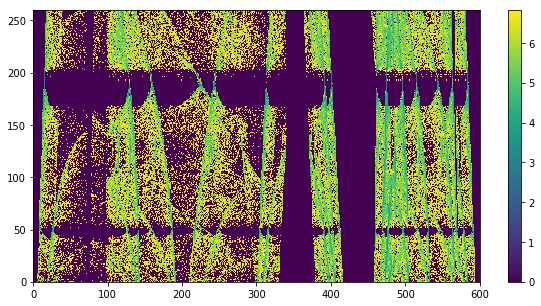

In [342]:
# 2d bin instead of point cloud

x_range = [-4., 4.3]
N_bins = 600

xmax_map = []
for i, max_x in zip(range(len(b_span)), all_max_x):
    x = np.asarray(max_x)

    x_scaled =  (x - x_range[0])/(x_range[1] - x_range[0])*N_bins

    p_i = np.bincount( np.floor(x_scaled).astype(int), minlength=N_bins)/len(x)
    
    xmax_map.append(p_i)
    
xmax_map = np.vstack(xmax_map)

xmax_map[xmax_map>0] = -np.log(xmax_map[xmax_map>0])

plt.figure(figsize=(10, 5))
plt.pcolormesh(xmax_map); plt.colorbar();

In [343]:
len(max_x)

877